In [1]:
import os
import math
import statistics
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.linear_model import LinearRegression
from sklearn import metrics

%matplotlib inline

In [2]:
def is_float(element):
    try:
        float(element)
        return True
    except ValueError:
        return False

In [3]:
def load_dict(path,prefix=""):
    if os.path.exists(path):
        with open(path, 'r') as fp:
            tmp = json.load(fp)
            return {("%s%s" % (prefix,k)):v for k,v in tmp.items()}
    return {}

# dDNNF

## Compilation + counting

In [4]:
def load_compilation_stats():
    path = os.path.join("xp_ddnnf","out","d4_compilation_stats")
    res={}
    for filename in os.listdir(path):
        fp = os.path.join(path,filename)
        tmp = load_dict(fp,"")
        if tmp["Compilation time"]!="NaN":
            res[filename[:-5]] = tmp
    return res

def load_ddnnf_counting_stats():
    path = os.path.join("xp_ddnnf","out","counting_stats")
    res={}
    for filename in os.listdir(path):
        fp = os.path.join(path,filename)
        res[filename[:-5]] = load_dict(fp,"")
    return res

data=load_compilation_stats()
tmp = load_ddnnf_counting_stats()
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])

data_df = pd.DataFrame.from_dict(data,orient='index')
data_df.head()

Number of variables  Number of clauses  \
s832a_15_7                          693               2017   
blasted_case106                     204                509   
blasted_case33                       51                143   
blasted_case63                       96                299   
polynomial.sk_7_25                  313               1027   

                    Number of literals  Compilation time Number of models  \
s832a_15_7                        4861          0.114819          3713024   
blasted_case106                   1367          0.064627    4398046511104   
blasted_case33                     391          0.032447             1024   
blasted_case63                     857          0.032563            35328   
polynomial.sk_7_25                2702          0.032743               64   

                          #models  parsing  count     total  
s832a_15_7                3713024    0.031  0.052  0.145307  
blasted_case106     4398046511104    0.024  0.027  0.104873  
blasted_case33               1024    0.014  0.008  0.074985  
blasted_case63              35328    0.014  0.009  0.075197  
polynomial.sk_7_25             64    0.014  0.010  0.077108

In [5]:
data_df["full_total"]=data_df["Compilation time"]+data_df["total"]

In [6]:
data_df.describe()

Number of variables  Number of clauses  Number of literals  \
count           221.000000         221.000000          221.000000   
mean            799.669683        4028.660633        12587.452489   
std            2347.612056       23067.154274        76601.360659   
min              14.000000          31.000000           67.000000   
25%             170.000000         518.000000         1205.000000   
50%             294.000000         870.000000         2158.000000   
75%             515.000000        1555.000000         4002.000000   
max           18570.000000      321897.000000       908392.000000   

       Compilation time     parsing       count       total  full_total  
count        221.000000  221.000000  221.000000  221.000000  221.000000  
mean           0.754115    0.038335    0.137710    0.230312    0.984427  
std            6.044640    0.044139    0.422038    0.460482    6.193038  
min            0.032447    0.009000    0.003000    0.053419    0.086471  
25%            0.032896    0.017000    0.017000    0.087163    0.121190  
50%            0.064868    0.024000    0.030000    0.109034    0.173902  
75%            0.165405    0.038000    0.077000    0.182430    0.404904  
max           86.882977    0.305000    4.897000    5.235040   87.355193

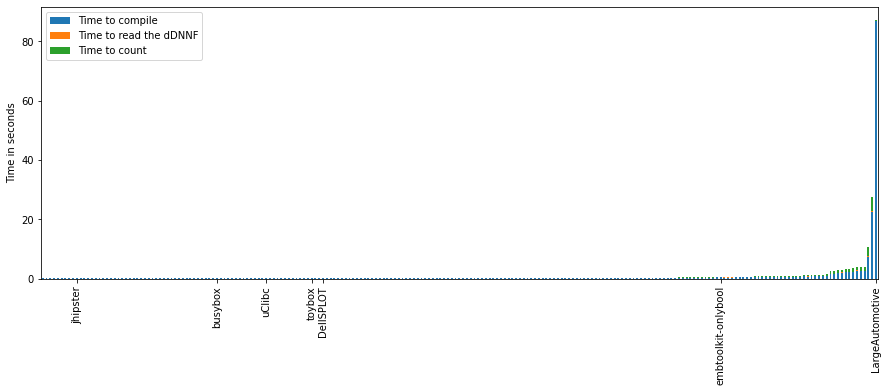

In [7]:
comp_key = "Time to compile"
parsing_key = "Time to read the dDNNF"
counting_key = "Time to count"

cols = [comp_key,parsing_key,counting_key]

sel_df = data_df.rename(columns={"parsing":parsing_key, "count":counting_key, "Compilation time":comp_key})

sel_df["Total time"] = sel_df[comp_key]+sel_df[parsing_key]+sel_df[counting_key]
sel_df = sel_df.sort_values("Total time",axis=0)

sel = {"uClibc","busybox","toybox","DellSPLOT","jhipster","LargeAutomotive","embtoolkit-onlybool","2.6.28.6"}
ticks = []
for i,x in enumerate(sel_df.index):
    if x in sel:
        ticks += [i]

fig, ax1 = plt.subplots(1, 1)

        
ax1 = sel_df[cols].plot(kind='bar', ax=ax1, stacked=True, figsize=(15,5),ylabel = "Time in seconds")
ax1.legend(loc='upper left')

ax1.set_xticks(ticks)
plt.show()

# Counting
## Count with dDNNF vs count SAT

In [8]:
def load_sat_counting_stats():
    path = os.path.join("xp_sat","out","cadical_count_stats")
    res={}
    for filename in os.listdir(path):
        fp = os.path.join(path,filename)
        tmp = load_dict(fp,"")
        if  tmp['count']=="UNSATISFIABLE": #aka success
            res[filename[:-5]] = {"time":tmp['total time']}
        if  tmp['count']=='NaN': #aka failure
            res[filename[:-5]] = {}
        if  tmp['count']!="UNSATISFIABLE" and tmp['count']!="NaN":
            print("Don't know how to handle key of file %s: %s" % (filename,tmp['count']))
    return res

data = load_sat_counting_stats()
tmp = load_ddnnf_counting_stats()
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])

data_df = pd.DataFrame.from_dict(data,orient='index')
data_df.head()

#models  parsing  count     total       time
s832a_15_7                3713024    0.031  0.052  0.145307        NaN
blasted_case106     4398046511104    0.024  0.027  0.104873        NaN
blasted_case33               1024    0.014  0.008  0.074985  58.957682
blasted_case63              35328    0.014  0.009  0.075197        NaN
polynomial.sk_7_25             64    0.014  0.010  0.077108   0.893865

In [9]:
data_df.describe()

parsing       count       total        time
count  221.000000  221.000000  221.000000   27.000000
mean     0.038335    0.137710    0.230312   66.060823
std      0.044139    0.422038    0.460482  114.545466
min      0.009000    0.003000    0.053419    0.034571
25%      0.017000    0.017000    0.087163    0.531576
50%      0.024000    0.030000    0.109034    3.063799
75%      0.038000    0.077000    0.182430  112.244467
max      0.305000    4.897000    5.235040  406.431450

The sat count method is capable of counting 27 instances of the benchmark while the #SAT can count 221 instances.

# Enum with dDNNF vs SAT

In [10]:
def load_ddnnf_enum_1_stats():
    path = os.path.join("xp_ddnnf","out","point_out_1")
    res={}
    for filename in os.listdir(path):
        res[filename[:-5]] = {}
        fp = os.path.join(path,filename)
        tmp = load_dict(fp,"")
        for key in ['parsing','preparation','satisfiability']:
            res[filename[:-5]]["ddnnf_sat_%s" % key] =np.mean([tmp[key2][key] for key2 in tmp])
    return res

def load_ddnnf_enum_10_stats():
    path = os.path.join("xp_ddnnf","out","point_out_10")
    res={}
    for filename in os.listdir(path):
        res[filename[:-5]] = {}
        fp = os.path.join(path,filename)
        tmp = load_dict(fp,"")
        for key in ['parsing','preparation','satisfiability']:
            res[filename[:-5]]["ddnnf_enum10_%s" % key] =np.mean([tmp[key2][key] for key2 in tmp])
    return res

def load_ddnnf_sampling_stats():
    path = os.path.join("xp_ddnnf","out","sampling_stats")
    res={}
    for filename in os.listdir(path):
        res[filename[:-5]] = {}
        fp = os.path.join(path,filename)
        tmp = load_dict(fp,"")
        for key in ['parsing','preparation','sampling']:
            res[filename[:-5]]["ddnnf_sampling_%s" % key] =np.mean([tmp[key2][key] for key2 in tmp])
    return res

data=load_compilation_stats()
tmp = load_ddnnf_enum_1_stats()
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])
tmp = load_ddnnf_enum_10_stats()
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])
tmp = load_ddnnf_sampling_stats()
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])
data_df = pd.DataFrame.from_dict(data,orient='index')
data_df.head()

Number of variables  Number of clauses  \
s832a_15_7                          693               2017   
blasted_case106                     204                509   
blasted_case33                       51                143   
blasted_case63                       96                299   
polynomial.sk_7_25                  313               1027   

                    Number of literals  Compilation time Number of models  \
s832a_15_7                        4861          0.114819          3713024   
blasted_case106                   1367          0.064627    4398046511104   
blasted_case33                     391          0.032447             1024   
blasted_case63                     857          0.032563            35328   
polynomial.sk_7_25                2702          0.032743               64   

                    ddnnf_sat_parsing  ddnnf_sat_preparation  \
s832a_15_7                     0.0310                 0.0506   
blasted_case106                0.0238                 0.0264   
blasted_case33                 0.0136                 0.0070   
blasted_case63                 0.0140                 0.0080   
polynomial.sk_7_25             0.0140                 0.0090   

                    ddnnf_sat_satisfiability  ddnnf_enum10_parsing  \
s832a_15_7                            0.0066                0.0308   
blasted_case106                       0.0040                0.0238   
blasted_case33                        0.0022                0.0134   
blasted_case63                        0.0030                0.0140   
polynomial.sk_7_25                    0.0040                0.0144   

                    ddnnf_enum10_preparation  ddnnf_enum10_satisfiability  \
s832a_15_7                            0.0504                       0.0168   
blasted_case106                       0.0268                       0.0086   
blasted_case33                        0.0070                       0.0058   
blasted_case63                        0.0080                       0.0074   
polynomial.sk_7_25                    0.0092                       0.0094   

                    ddnnf_sampling_parsing  ddnnf_sampling_preparation  \
s832a_15_7                          0.0304                      0.0502   
blasted_case106                     0.0234                      0.0272   
blasted_case33                      0.0138                      0.0070   
blasted_case63                      0.0140                      0.0080   
polynomial.sk_7_25                  0.0140                      0.0090   

                    ddnnf_sampling_sampling  
s832a_15_7                           0.0166  
blasted_case106                      0.0090  
blasted_case33                       0.0058  
blasted_case63                       0.0078  
polynomial.sk_7_25                   0.0090

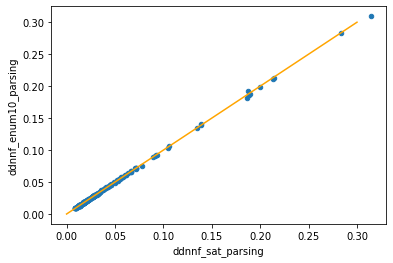

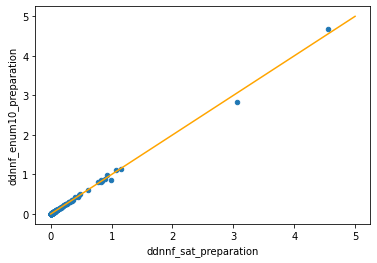

In [11]:
# Check that parsing and annotation in the same in the two xps

data_df.plot("ddnnf_sat_parsing","ddnnf_enum10_parsing",kind="scatter")
plt.plot([0,0.3],[0,0.3],'-',color="orange")
plt.show()
data_df.plot("ddnnf_sat_preparation","ddnnf_enum10_preparation",kind="scatter")
plt.plot([0,5],[0,5],'-',color="orange")
plt.show()

In [12]:
data_df.describe()

Number of variables  Number of clauses  Number of literals  \
count           221.000000         221.000000          221.000000   
mean            799.669683        4028.660633        12587.452489   
std            2347.612056       23067.154274        76601.360659   
min              14.000000          31.000000           67.000000   
25%             170.000000         518.000000         1205.000000   
50%             294.000000         870.000000         2158.000000   
75%             515.000000        1555.000000         4002.000000   
max           18570.000000      321897.000000       908392.000000   

       Compilation time  ddnnf_sat_parsing  ddnnf_sat_preparation  \
count        221.000000         221.000000             221.000000   
mean           0.754115           0.038276               0.135418   
std            6.044640           0.044658               0.409847   
min            0.032447           0.009000               0.002000   
25%            0.032896           0.017000               0.016000   
50%            0.064868           0.023200               0.027600   
75%            0.165405           0.038400               0.075000   
max           86.882977           0.314400               4.555600   

       ddnnf_sat_satisfiability  ddnnf_enum10_parsing  \
count                221.000000            221.000000   
mean                   0.006720              0.038281   
std                    0.010278              0.044326   
min                    0.002000              0.009000   
25%                    0.004000              0.017000   
50%                    0.004800              0.023200   
75%                    0.006400              0.039200   
max                    0.110000              0.309200   

       ddnnf_enum10_preparation  ddnnf_enum10_satisfiability  \
count                221.000000                   221.000000   
mean                   0.135171                     0.019183   
std                    0.409206                     0.042765   
min                    0.002000                     0.002800   
25%                    0.015800                     0.008600   
50%                    0.028200                     0.011200   
75%                    0.075600                     0.016000   
max                    4.681000                     0.405400   

       ddnnf_sampling_parsing  ddnnf_sampling_preparation  \
count              221.000000                  221.000000   
mean                 0.038180                    0.135329   
std                  0.044322                    0.410701   
min                  0.009000                    0.002000   
25%                  0.017000                    0.016000   
50%                  0.023000                    0.028000   
75%                  0.038600                    0.074400   
max                  0.309400                    4.630000   

       ddnnf_sampling_sampling  
count               221.000000  
mean                  0.019110  
std                   0.042184  
min                   0.003000  
25%                   0.008600  
50%                   0.011000  
75%                   0.016000  
max                   0.391000

In [13]:
def extract_value(data,idx):
    times = list(data.items())
    sorted(times,key=lambda x:int(x[0]))
    times = [x[1] for x in times]
    if idx < len(times): # worked
        if times[idx]=="NaN":
            return -1
        return times[idx]
    if times[-1] == 'UNSATISFIABLE': # work but not enough model in the cnf, still a success
        return times[-1]
    return -1

def load_sat_enum_stats(col_name,idx):
    path = os.path.join("xp_sat","out","cadical_enum_10_stats")
    res={}
    for filename in os.listdir(path):
        res[filename[:-5]] = {}
        fp = os.path.join(path,filename)
        tmp = load_dict(fp,"")
        times = [extract_value(tmp[key],idx) for key in tmp if str(idx) in tmp[key]]
        if -1 not in times and len(times)==5:
            res[filename[:-5]][col_name] = np.mean(times)
    return res

tmp = load_sat_enum_stats("sat_enum10",9)
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])
tmp = load_sat_enum_stats("sat_satisfiability",0)
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])
data_df = pd.DataFrame.from_dict(data,orient='index')
data_df.head()

Number of variables  Number of clauses  \
s832a_15_7                        693.0             2017.0   
blasted_case106                   204.0              509.0   
blasted_case33                     51.0              143.0   
blasted_case63                     96.0              299.0   
polynomial.sk_7_25                313.0             1027.0   

                    Number of literals  Compilation time Number of models  \
s832a_15_7                      4861.0          0.114819          3713024   
blasted_case106                 1367.0          0.064627    4398046511104   
blasted_case33                   391.0          0.032447             1024   
blasted_case63                   857.0          0.032563            35328   
polynomial.sk_7_25              2702.0          0.032743               64   

                    ddnnf_sat_parsing  ddnnf_sat_preparation  \
s832a_15_7                     0.0310                 0.0506   
blasted_case106                0.0238                 0.0264   
blasted_case33                 0.0136                 0.0070   
blasted_case63                 0.0140                 0.0080   
polynomial.sk_7_25             0.0140                 0.0090   

                    ddnnf_sat_satisfiability  ddnnf_enum10_parsing  \
s832a_15_7                            0.0066                0.0308   
blasted_case106                       0.0040                0.0238   
blasted_case33                        0.0022                0.0134   
blasted_case63                        0.0030                0.0140   
polynomial.sk_7_25                    0.0040                0.0144   

                    ddnnf_enum10_preparation  ddnnf_enum10_satisfiability  \
s832a_15_7                            0.0504                       0.0168   
blasted_case106                       0.0268                       0.0086   
blasted_case33                        0.0070                       0.0058   
blasted_case63                        0.0080                       0.0074   
polynomial.sk_7_25                    0.0092                       0.0094   

                    ddnnf_sampling_parsing  ddnnf_sampling_preparation  \
s832a_15_7                          0.0304                      0.0502   
blasted_case106                     0.0234                      0.0272   
blasted_case33                      0.0138                      0.0070   
blasted_case63                      0.0140                      0.0080   
polynomial.sk_7_25                  0.0140                      0.0090   

                    ddnnf_sampling_sampling  sat_enum10  sat_satisfiability  
s832a_15_7                           0.0166    0.120271            0.013491  
blasted_case106                      0.0090    0.092432            0.008048  
blasted_case33                       0.0058    0.069980            0.007078  
blasted_case63                       0.0078    0.089172            0.011435  
polynomial.sk_7_25                   0.0090    0.107412            0.010677

In [14]:
data_df['Satisfiability with dDNNF']=(data_df["Compilation time"]+data_df["ddnnf_sat_parsing"]+
                                    data_df["ddnnf_sat_preparation"]+ data_df["ddnnf_sat_satisfiability"])
data_df['Enum 10 with dDNNF']=(data_df["Compilation time"]+data_df["ddnnf_enum10_parsing"]+
                                    data_df["ddnnf_enum10_preparation"]+ data_df["ddnnf_enum10_satisfiability"])
data_df['Sampling with dDNNF']=(data_df["Compilation time"]+data_df["ddnnf_sampling_parsing"]+
                                    data_df["ddnnf_sampling_preparation"]+ data_df["ddnnf_sampling_sampling"])

In [15]:
sel_df = data_df[['Satisfiability with dDNNF','Enum 10 with dDNNF','Sampling with dDNNF',"sat_satisfiability","sat_enum10"]]
sel_df.describe()

Satisfiability with dDNNF  Enum 10 with dDNNF  Sampling with dDNNF  \
count                 221.000000          221.000000           221.000000   
mean                    0.934529            0.946750             0.946734   
std                     6.196697            6.215219             6.215055   
min                     0.045494            0.046451             0.046494   
25%                     0.071928            0.077108             0.077471   
50%                     0.120668            0.128609             0.127052   
75%                     0.354603            0.366590             0.364177   
max                    87.444177           87.727977            87.725777   

       sat_satisfiability  sat_enum10  
count          218.000000  216.000000  
mean             0.014051    0.120404  
std              0.037065    0.220650  
min              0.005177    0.051453  
25%              0.008385    0.083648  
50%              0.010474    0.101748  
75%              0.012276    0.112406  
max              0.536030    3.172037

In [16]:
data_df['Satisfiability with dDNNF_no_compil']=(data_df["ddnnf_sat_parsing"]+
                                    data_df["ddnnf_sat_preparation"]+ data_df["ddnnf_sat_satisfiability"])
data_df['Enum 10 with dDNNF_no_compil']=(data_df["ddnnf_enum10_parsing"]+
                                    data_df["ddnnf_enum10_preparation"]+ data_df["ddnnf_enum10_satisfiability"])
data_df['Sampling with dDNNF_no_compil']=(data_df["ddnnf_sampling_parsing"]+
                                    data_df["ddnnf_sampling_preparation"]+ data_df["ddnnf_sampling_sampling"])
sel_df = data_df[['Satisfiability with dDNNF_no_compil','Enum 10 with dDNNF_no_compil',
                  'Sampling with dDNNF_no_compil',"sat_satisfiability","sat_enum10"]]
sel_df.describe()

Satisfiability with dDNNF_no_compil  Enum 10 with dDNNF_no_compil  \
count                           221.000000                    221.000000   
mean                              0.180414                      0.192635   
std                               0.450302                      0.452563   
min                               0.013000                      0.013800   
25%                               0.038400                      0.043400   
50%                               0.054400                      0.065800   
75%                               0.135200                      0.151000   
max                               4.849200                      4.985600   

       Sampling with dDNNF_no_compil  sat_satisfiability  sat_enum10  
count                     221.000000          218.000000  216.000000  
mean                        0.192619            0.014051    0.120404  
std                         0.454100            0.037065    0.220650  
min                         0.014000            0.005177    0.051453  
25%                         0.043400            0.008385    0.083648  
50%                         0.065200            0.010474    0.101748  
75%                         0.149000            0.012276    0.112406  
max                         4.933000            0.536030    3.172037

# Top 10 config 
## with dDNNF

In [17]:
data=load_compilation_stats()

In [18]:
def load_ddnnf_top_10_stats(directory,col_name):
    path = os.path.join("xp_ddnnf","out",directory)
    res={}
    for filename in os.listdir(path):
        res[filename[:-5]] = {}
        fp = os.path.join(path,filename)
        tmp = load_dict(fp,"")
        for key in ['parsing','smoothing','top']:
            res[filename[:-5]][col_name % key] =np.mean([tmp[key2][key] for key2 in tmp])
        res[filename[:-5]]={col_name % "total":sum([res[filename[:-5]][col_name % key] for 
                                        key in ['parsing','smoothing','top'] ])}
    return res

data = load_ddnnf_top_10_stats('top10_config_jddnnf_1','ddnnf_top10_1_%s')
tmp = load_ddnnf_top_10_stats('top10_config_jddnnf_100','ddnnf_top10_100_%s')
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])
tmp = load_ddnnf_top_10_stats('top10_config_jddnnf_10000','ddnnf_top10_10000_%s')
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])
tmp = load_ddnnf_top_10_stats('top10_config_jddnnf_1000000','ddnnf_top10_1000000_%s')
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])
data_df = pd.DataFrame.from_dict(data,orient='index')
data_df.head()

ddnnf_top10_1_total  ddnnf_top10_100_total  \
s832a_15_7                       0.1462                 0.1472   
blasted_case106                  0.0816                 0.0836   
blasted_case33                   0.0320                 0.0336   
blasted_case63                   0.0358                 0.0364   
polynomial.sk_7_25               0.0380                 0.0386   

                    ddnnf_top10_10000_total  ddnnf_top10_1000000_total  
s832a_15_7                           0.1496                     0.1470  
blasted_case106                      0.0852                     0.0852  
blasted_case33                       0.0330                     0.0346  
blasted_case63                       0.0364                     0.0360  
polynomial.sk_7_25                   0.0384                     0.0392

In [19]:
data_df.describe()

ddnnf_top10_1_total  ddnnf_top10_100_total  ddnnf_top10_10000_total  \
count           221.000000             221.000000               221.000000   
mean              0.336432               0.343420                 0.342271   
std               0.798018               0.827989                 0.825085   
min               0.014600               0.015000                 0.014200   
25%               0.054800               0.055600                 0.055400   
50%               0.091200               0.091000                 0.090600   
75%               0.266800               0.271400                 0.273200   
max               7.560000               7.835000                 7.834000   

       ddnnf_top10_1000000_total  
count                 221.000000  
mean                    0.339686  
std                     0.822843  
min                     0.015000  
25%                     0.055200  
50%                     0.090800  
75%                     0.264600  
max                     7.959200

no influence of the limit k for the top 10 with dDNNF and stability of the running time

## with MaxHS

In [20]:
def extract_value(times,idx):
    if idx < len(times) and is_float(times[idx]): # worked
        return times[idx]
    if (len(times)==0):
        return -1
    if times[-1] == 'UNSATISFIABLE' or times[-1] == 'UNSAT': # work but not enough model in the cnf, still a success
        return times[-2]
    return -1

def load_top10_stats(directory,col_name):
    res={}
    for filename in os.listdir(directory):
        res[filename[:-5]] = {}
        fp = os.path.join(directory,filename)
        tmp = load_dict(fp,"")
        times = [extract_value(tmp[key],9) for key in tmp]
        if -1 not in times and len(times)==5:
            res[filename[:-5]][col_name] = np.mean(times)
    return res


data = load_top10_stats(os.path.join("xp_maxsat","out",'top10_config_maxhs_1'),'maxhs_top10_1')
tmp = load_top10_stats(os.path.join("xp_maxsat","out",'top10_config_maxhs_100'),'maxhs_top10_100')
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])
tmp = load_top10_stats(os.path.join("xp_maxsat","out",'top10_config_maxhs_10000'),'maxhs_top10_10000')
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])
tmp = load_top10_stats(os.path.join("xp_maxsat","out",'top10_config_maxhs_1000000'),'maxhs_top10_1000000')
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])
data_df = pd.DataFrame.from_dict(data,orient='index')
data_df.head()

maxhs_top10_1  maxhs_top10_100  maxhs_top10_10000  \
s832a_15_7               0.392455        17.935408          19.525234   
blasted_case106          0.088617         0.929605           1.001626   
blasted_case33           0.166426         0.601853           0.678740   
blasted_case63           0.107977         0.629019           0.758054   
polynomial.sk_7_25       0.180883         1.036416           1.274128   

                    maxhs_top10_1000000  
s832a_15_7                    21.723258  
blasted_case106                1.062545  
blasted_case33                 0.754776  
blasted_case63                 0.803286  
polynomial.sk_7_25             1.235391

In [21]:
data_df.describe()

maxhs_top10_1  maxhs_top10_100  maxhs_top10_10000  maxhs_top10_1000000
count     222.000000       222.000000         222.000000           222.000000
mean        0.485317         3.700592           3.918526             3.934571
std         2.039078         7.025704           7.640071             7.743261
min         0.021986         0.146266           0.126157             0.125017
25%         0.151487         0.843288           0.936799             0.961231
50%         0.209483         1.405846           1.523355             1.523612
75%         0.288430         3.400784           3.162730             3.130918
max        26.569045        55.671245          60.978738            60.359178

Only a slight slowdown is observed when k increase

## with Sat4J

In [22]:
data = load_top10_stats(os.path.join("xp_sat4j","out",'top10_config_sat4j_1'),'maxhs_top10_1')
tmp = load_top10_stats(os.path.join("xp_sat4j","out",'top10_config_sat4j_100'),'maxhs_top10_100')
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])
tmp = load_top10_stats(os.path.join("xp_sat4j","out",'top10_config_sat4j_10000'),'maxhs_top10_10000')
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])
tmp = load_top10_stats(os.path.join("xp_sat4j","out",'top10_config_sat4j_1000000'),'maxhs_top10_1000000')
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])
data_df = pd.DataFrame.from_dict(data,orient='index')
data_df.head()

maxhs_top10_1  maxhs_top10_100  maxhs_top10_10000  \
s832a_15_7                 0.1394           6.0564                NaN   
blasted_case106            0.1230              NaN                NaN   
blasted_case33             0.1036           0.2036                NaN   
blasted_case63             0.1226           2.7248                NaN   
polynomial.sk_7_25         0.1374           0.4592           330.2392   

                    maxhs_top10_1000000  
s832a_15_7                          NaN  
blasted_case106                     NaN  
blasted_case33                      NaN  
blasted_case63                      NaN  
polynomial.sk_7_25                  NaN

In [23]:
data_df.describe()

maxhs_top10_1  maxhs_top10_100  maxhs_top10_10000  maxhs_top10_1000000
count     220.000000       184.000000          44.000000             2.000000
mean        0.152108        14.297437         129.491209           144.256800
std         0.100440        33.276208         136.064819            73.471223
min         0.095200         0.115200           0.403000            92.304800
25%         0.120400         0.446250          12.451100           118.280800
50%         0.131300         2.734600          69.628700           144.256800
75%         0.145250         9.315550         259.493500           170.232800
max         1.157000       242.677400         404.497600           196.208800

We observe a big increase of the failing rate

# Top 10 value
## with dDNNF

In [24]:
data = load_ddnnf_top_10_stats('top10_value_jddnnf_1','ddnnf_top10_1_%s')
tmp = load_ddnnf_top_10_stats('top10_value_jddnnf_100','ddnnf_top10_100_%s')
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])
tmp = load_ddnnf_top_10_stats('top10_value_jddnnf_10000','ddnnf_top10_10000_%s')
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])
tmp = load_ddnnf_top_10_stats('top10_value_jddnnf_1000000','ddnnf_top10_1000000_%s')
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])
data_df = pd.DataFrame.from_dict(data,orient='index')
data_df.head()

ddnnf_top10_1_total  ddnnf_top10_100_total  \
s832a_15_7                       0.1404                 0.1416   
blasted_case106                  0.0768                 0.0824   
blasted_case33                   0.0302                 0.0314   
blasted_case63                   0.0328                 0.0342   
polynomial.sk_7_25               0.0348                 0.0356   

                    ddnnf_top10_10000_total  ddnnf_top10_1000000_total  
s832a_15_7                           0.1432                     0.1414  
blasted_case106                      0.0824                     0.0804  
blasted_case33                       0.0316                     0.0310  
blasted_case63                       0.0336                     0.0342  
polynomial.sk_7_25                   0.0352                     0.0346

In [25]:
data_df.describe()

ddnnf_top10_1_total  ddnnf_top10_100_total  ddnnf_top10_10000_total  \
count           221.000000             221.000000               221.000000   
mean              0.326102               0.327586                 0.328233   
std               0.816038               0.802670                 0.804130   
min               0.013200               0.013400                 0.013400   
25%               0.050800               0.051800                 0.051600   
50%               0.078000               0.082400                 0.082400   
75%               0.247600               0.249800                 0.253400   
max               7.821200               7.561400                 7.669800   

       ddnnf_top10_1000000_total  
count                 221.000000  
mean                    0.324013  
std                     0.789753  
min                     0.014000  
25%                     0.051600  
50%                     0.080600  
75%                     0.247600  
max                     7.514600

## with MaxHS

In [26]:
data = load_top10_stats(os.path.join("xp_maxsat","out",'top10_value_maxhs_1'),'maxhs_top10_1')
tmp = load_top10_stats(os.path.join("xp_maxsat","out",'top10_value_maxhs_100'),'maxhs_top10_100')
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])
tmp = load_top10_stats(os.path.join("xp_maxsat","out",'top10_value_maxhs_10000'),'maxhs_top10_10000')
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])
tmp = load_top10_stats(os.path.join("xp_maxsat","out",'top10_value_maxhs_1000000'),'maxhs_top10_1000000')
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])
data_df = pd.DataFrame.from_dict(data,orient='index')
data_df.head()

maxhs_top10_100  maxhs_top10_10000  maxhs_top10_1000000  \
s832a_15_7                20.617019          20.337907            21.594102   
blasted_case106            1.502389           1.792064             0.986154   
blasted_case33             0.483462           0.554211             0.604825   
blasted_case63             0.479605           0.398013             0.445259   
polynomial.sk_7_25         1.052327           1.171440             1.050027   

                    maxhs_top10_1  
s832a_15_7                    NaN  
blasted_case106               NaN  
blasted_case33         109.115830  
blasted_case63                NaN  
polynomial.sk_7_25       2.586377

In [27]:
data_df.describe()

maxhs_top10_100  maxhs_top10_10000  maxhs_top10_1000000  maxhs_top10_1
count       204.000000         220.000000           222.000000      25.000000
mean          6.378496           4.727514             4.449879      34.624792
std          12.350764          15.924123            10.807376      50.350433
min           0.034001           0.039107             0.057563       0.040186
25%           0.999684           0.804597             0.856893       1.091697
50%           2.304916           1.386197             1.383124       8.566852
75%           4.791052           3.646297             3.478983      53.156899
max          73.032683         212.344404            96.716134     154.572289

## with SAT4J

In [28]:
data = load_top10_stats(os.path.join("xp_sat4j","out",'top10_value_sat4j_1'),'xp_sat4j_top10_1')
tmp = load_top10_stats(os.path.join("xp_sat4j","out",'top10_value_sat4j_100'),'xp_sat4j_top10_100')
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])
tmp = load_top10_stats(os.path.join("xp_sat4j","out",'top10_value_sat4j_10000'),'xp_sat4j_top10_10000')
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])
tmp = load_top10_stats(os.path.join("xp_sat4j","out",'top10_value_sat4j_1000000'),'xp_sat4j_top10_1000000')
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])
data_df = pd.DataFrame.from_dict(data,orient='index')
data_df.head()

xp_sat4j_top10_1  xp_sat4j_top10_100  \
s832a_15_7                    7.3304              3.1102   
blasted_case33                0.1410              0.1196   
blasted_case63                0.4664              0.2892   
polynomial.sk_7_25            0.2158              0.1956   
s382_7_4                     24.4862              6.0540   

                    xp_sat4j_top10_10000  xp_sat4j_top10_1000000  
s832a_15_7                        2.8454                  4.9374  
blasted_case33                    0.1202                  0.1148  
blasted_case63                    0.2798                  0.2202  
polynomial.sk_7_25                0.1968                  0.1910  
s382_7_4                          5.8282                  6.6070

In [29]:
data_df.describe()

xp_sat4j_top10_1  xp_sat4j_top10_100  xp_sat4j_top10_10000  \
count        123.000000          180.000000            185.000000   
mean          36.756036           12.656943             13.235636   
std           83.162955           34.000990             31.776544   
min            0.102800            0.075600              0.076400   
25%            0.467800            0.236150              0.239200   
50%            2.922400            0.894300              0.889200   
75%           27.087900            8.733550              9.963800   
max          542.091200          289.401600            255.567400   

       xp_sat4j_top10_1000000  
count              184.000000  
mean                13.309890  
std                 34.465593  
min                  0.076400  
25%                  0.215200  
50%                  0.865100  
75%                  9.101750  
max                211.654400

# Scalability

## with dDNNF

In [49]:
res = {}
for filename in os.listdir(os.path.join("xp_ddnnf","out","max_config_jddnnf")):
    res[filename[:-5]] = {}
    fp = os.path.join("xp_ddnnf","out","max_config_jddnnf",filename)
    tmp = load_dict(fp,"")
    for key in ['parsing','smoothing','topk']:
        res[filename[:-5]]["ddnnf_max_%s" % key] =np.mean([tmp[key2][key] for key2 in tmp])
    res[filename[:-5]]["ddnnf_max_total"] = sum([res[filename[:-5]][key2] for key2 in res[filename[:-5]]])
for k,v in res.items():
    print("%s: %f" % (k,v['ddnnf_max_total']))

LargeAutomotive_35000: 633.597200
LargeAutomotive_1000: 19.802600
LargeAutomotive_25000: 454.704600
LargeAutomotive_45000: 782.364600
LargeAutomotive_40000: 688.681600
LargeAutomotive_75000: 1457.300000
LargeAutomotive_10000: 173.069200
LargeAutomotive_50000: 972.450000
LargeAutomotive_30000: 534.056000


## with MaxHS

In [30]:
def load_max_maxsat_stats(directory,col_name):
    path = os.path.join("xp_maxsat","out",directory)
    res={}
    for filename in os.listdir(path):
        res[filename[:-5]] = {}
        fp = os.path.join(path,filename)
        tmp = load_dict(fp,"")
        nbs = []
        for key in tmp:
            res[filename[:-5]][col_name % str(key)] = len([x for x in tmp[key] if is_float(x) and x<600])
            nbs += [ res[filename[:-5]][col_name % str(key)] ]
        res[filename[:-5]][col_name % "mean"] =np.mean(nbs)
    return res

data = load_max_maxsat_stats("limit_config_maxhs_1","max_with_limit_1_%s")
tmp = load_max_maxsat_stats("limit_config_maxhs_100","max_with_limit_100_%s")
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])
tmp = load_max_maxsat_stats("limit_config_maxhs_10000","max_with_limit_10000_%s")
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])
tmp = load_max_maxsat_stats("limit_config_maxhs_1000000","max_with_limit_1000000_%s")
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])

In [31]:
data

{'2.6.28.6': {'max_with_limit_1_0': 229,
  'max_with_limit_1_1': 230,
  'max_with_limit_1_2': 230,
  'max_with_limit_1_3': 230,
  'max_with_limit_1_4': 229,
  'max_with_limit_1_mean': 229.6,
  'max_with_limit_100_0': 90,
  'max_with_limit_100_1': 88,
  'max_with_limit_100_2': 118,
  'max_with_limit_100_3': 91,
  'max_with_limit_100_4': 90,
  'max_with_limit_100_mean': 95.4,
  'max_with_limit_10000_0': 89,
  'max_with_limit_10000_1': 89,
  'max_with_limit_10000_2': 91,
  'max_with_limit_10000_3': 89,
  'max_with_limit_10000_4': 87,
  'max_with_limit_10000_mean': 89.0,
  'max_with_limit_1000000_0': 62,
  'max_with_limit_1000000_1': 59,
  'max_with_limit_1000000_2': 60,
  'max_with_limit_1000000_3': 60,
  'max_with_limit_1000000_4': 59,
  'max_with_limit_1000000_mean': 60.0},
 'LargeAutomotive': {'max_with_limit_1_0': 282,
  'max_with_limit_1_1': 280,
  'max_with_limit_1_2': 280,
  'max_with_limit_1_3': 281,
  'max_with_limit_1_4': 280,
  'max_with_limit_1_mean': 280.6,
  'max_with_limit_

We see a slow down wich is coherent with what was observed in the top10 config.

# WIth Sat4J

In [32]:
def load_max_sat4j_stats(directory,col_name):
    path = os.path.join("xp_sat4j","out",directory)
    res={}
    for filename in os.listdir(path):
        res[filename[:-5]] = {}
        fp = os.path.join(path,filename)
        tmp = load_dict(fp,"")
        nbs = []
        for key in tmp:
            res[filename[:-5]][col_name % str(key)] = tmp[key][1]
            nbs += [ res[filename[:-5]][col_name % str(key)] ]
        res[filename[:-5]][col_name % "mean"] =np.mean(nbs)
    return res

data = load_max_sat4j_stats("limit_config_sat4j_100","max_with_limit_100_%s")
tmp = load_max_sat4j_stats("limit_config_sat4j_10000","max_with_limit_10000_%s")
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])
tmp = load_max_sat4j_stats("limit_config_sat4j_1000000","max_with_limit_1000000_%s")
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])
data

{'2.6.28.6': {'max_with_limit_100_0': 104452,
  'max_with_limit_100_1': 111122,
  'max_with_limit_100_2': 115590,
  'max_with_limit_100_3': 101093,
  'max_with_limit_100_4': 65961,
  'max_with_limit_100_mean': 99643.6,
  'max_with_limit_10000_0': 31281,
  'max_with_limit_10000_1': 12818,
  'max_with_limit_10000_2': 804,
  'max_with_limit_10000_3': 2113,
  'max_with_limit_10000_4': 3195,
  'max_with_limit_10000_mean': 10042.2,
  'max_with_limit_1000000_0': 2,
  'max_with_limit_1000000_1': 1,
  'max_with_limit_1000000_2': 1,
  'max_with_limit_1000000_3': 1,
  'max_with_limit_1000000_4': 1,
  'max_with_limit_1000000_mean': 1.2},
 'LargeAutomotive': {'max_with_limit_100_0': 0,
  'max_with_limit_100_1': 0,
  'max_with_limit_100_2': 0,
  'max_with_limit_100_3': 0,
  'max_with_limit_100_4': 0,
  'max_with_limit_100_mean': 0.0,
  'max_with_limit_10000_0': 0,
  'max_with_limit_10000_1': 0,
  'max_with_limit_10000_2': 0,
  'max_with_limit_10000_3': 0,
  'max_with_limit_10000_4': 0,
  'max_with_l

# Scatter plot top10 config dDNNF vs MaxHS

In [33]:
data = {}
data = load_ddnnf_top_10_stats('top10_config_jddnnf_1000000','ddnnf_top10_1000000_%s')
tmp = load_top10_stats(os.path.join("xp_maxsat","out",'top10_config_maxhs_1000000'),'maxhs_top10_1000000')
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])
tmp = load_compilation_stats()
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])
data_df = pd.DataFrame.from_dict(data,orient='index')
data_df.head()

ddnnf_top10_1000000_total  maxhs_top10_1000000  \
s832a_15_7                             0.1470            21.723258   
blasted_case106                        0.0852             1.062545   
blasted_case33                         0.0346             0.754776   
blasted_case63                         0.0360             0.803286   
polynomial.sk_7_25                     0.0392             1.235391   

                    Number of variables  Number of clauses  \
s832a_15_7                        693.0             2017.0   
blasted_case106                   204.0              509.0   
blasted_case33                     51.0              143.0   
blasted_case63                     96.0              299.0   
polynomial.sk_7_25                313.0             1027.0   

                    Number of literals  Compilation time Number of models  
s832a_15_7                      4861.0          0.114819          3713024  
blasted_case106                 1367.0          0.064627    4398046511104  
blasted_case33                   391.0          0.032447             1024  
blasted_case63                   857.0          0.032563            35328  
polynomial.sk_7_25              2702.0          0.032743               64

In [34]:
timeout = 600
key_total_dDNNF = "Top 10 config with dDNNF (Compilation included in seconds)"
key_total_maxsat = "Top 10 config with MaxHS (in seconds)"

data_df[key_total_dDNNF] = data_df["Compilation time"]+data_df["ddnnf_top10_1000000_total"]
data_df.loc[data_df[[key_total_dDNNF]].isnull().any(axis=1),key_total_dDNNF] = timeout

data_df[key_total_maxsat] = data_df["maxhs_top10_1000000"]
data_df.loc[data_df[[key_total_maxsat]].isnull().any(axis=1),key_total_maxsat] = timeout

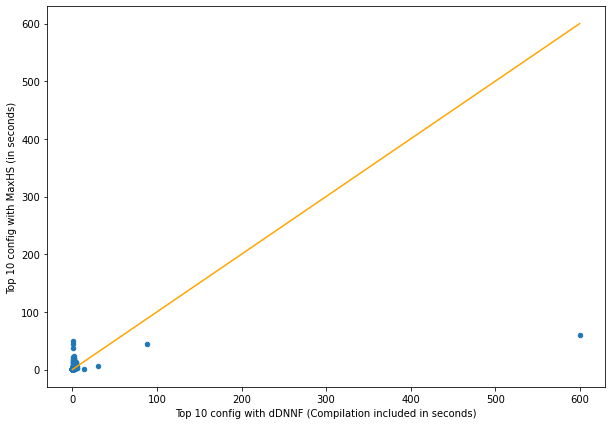

In [35]:
# timeout set at 10 minutes and 100 models
data_df.plot(key_total_dDNNF,key_total_maxsat,kind="scatter",figsize=(10,7))
plt.plot([0,600],[0,600],'-',color="orange")
#plt.savefig(os.path.join('figure','maxhs_enum.png'))
plt.show()

# Scatter plot top10 config dDNNF vs MaxHS

In [36]:
data={}
data = load_ddnnf_top_10_stats('top10_value_jddnnf_1000000','ddnnf_top10_1000000_%s')
tmp = load_top10_stats(os.path.join("xp_maxsat","out",'top10_value_maxhs_1000000'),'maxhs_top10_1000000')
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])
tmp = load_compilation_stats()
for key in tmp:
    if key not in data:
        data[key]={}
    data[key].update(tmp[key])
data_df = pd.DataFrame.from_dict(data,orient='index')
data_df.head()

ddnnf_top10_1000000_total  maxhs_top10_1000000  \
s832a_15_7                             0.1414            21.594102   
blasted_case106                        0.0804             0.986154   
blasted_case33                         0.0310             0.604825   
blasted_case63                         0.0342             0.445259   
polynomial.sk_7_25                     0.0346             1.050027   

                    Number of variables  Number of clauses  \
s832a_15_7                        693.0             2017.0   
blasted_case106                   204.0              509.0   
blasted_case33                     51.0              143.0   
blasted_case63                     96.0              299.0   
polynomial.sk_7_25                313.0             1027.0   

                    Number of literals  Compilation time Number of models  
s832a_15_7                      4861.0          0.114819          3713024  
blasted_case106                 1367.0          0.064627    4398046511104  
blasted_case33                   391.0          0.032447             1024  
blasted_case63                   857.0          0.032563            35328  
polynomial.sk_7_25              2702.0          0.032743               64

In [37]:
timeout = 600
key_total_dDNNF = "Top 10 value with dDNNF (Compilation included in seconds)"
key_total_maxsat = "Top 10 value with MaxHS (in seconds)"

data_df[key_total_dDNNF] = data_df["Compilation time"]+data_df["ddnnf_top10_1000000_total"]
data_df.loc[data_df[[key_total_dDNNF]].isnull().any(axis=1),key_total_dDNNF] = timeout

data_df[key_total_maxsat] = data_df["maxhs_top10_1000000"]
data_df.loc[data_df[[key_total_maxsat]].isnull().any(axis=1),key_total_maxsat] = timeout

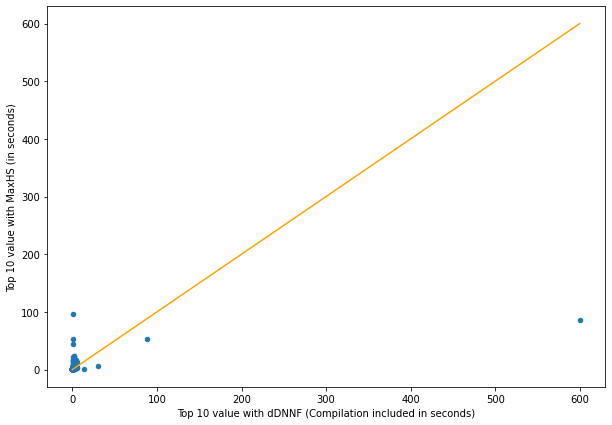

In [38]:
# timeout set at 10 minutes and 100 models
data_df.plot(key_total_dDNNF,key_total_maxsat,kind="scatter",figsize=(10,7))
plt.plot([0,600],[0,600],'-',color="orange")
#plt.savefig(os.path.join('figure','maxhs_enum.png'))
plt.show()